In [1]:
import os
from os.path import join
import random
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from skimage import measure
from torch.utils.data import Dataset, DataLoader
import torchio as tio

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
seed = 42
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)

In [2]:
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

__Python VERSION: 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:43:09) [GCC 12.3.0]
__pyTorch VERSION: 2.1.2+cu121
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0
__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__Devices
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 7 MiB, 81042 MiB
1, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 1000 MiB, 80049 MiB
2, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 1008 MiB, 80041 MiB
3, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 7 MiB, 81042 MiB
4, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 7 MiB, 81042 MiB
5, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 7 MiB, 81042 MiB
6, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 7 MiB, 81042 MiB
7, NVIDIA A100-SXM4-80GB, 535.129.03, 

In [3]:
from utils.loading_utils import *
from visualization.visualization import *
from ml.dataset_ import *

In [5]:
# QUICK GUIDE
# This is just for checking some data and visualizing it; we will/can not use this in the final pipeline; just for understanding how the data loader etc works...

root_dir = "./MICCAI-LH-BraTS2025-MET-Challenge-Validation/"

# load only a subset of the data

# first extract all cases and their contents from dir (only names)
case_contents = inspect_case_contents(root_dir)

# load some cases... limit specifies how many cases to load, seed is used for random sampling (no limit = all from dir)
loaded_cases = load_all_cases(root_dir, case_contents, limit=1, seed=5)
print(f"Total cases loaded: {len(loaded_cases)}")

# t2 not always available, validation dir has no segmentation data -> values are None if not avail
first_case = next(iter(loaded_cases)) # returns string with case name
print(f"First case: {first_case}")

# load data itself
first_case_ = loaded_cases[first_case] # returns dict of dict:{data, info}; info might be relevant if we want to apply transformations etc.
print(f"{list(first_case_.keys())}")

# modalities in the first case
print(f"Modalities in first case ({first_case}): {list(first_case_['data'].keys())}")
print(f"Modality t1n: ({first_case}): {first_case_['data']['t1n'].shape}")
print(f"Modality seg: ({first_case}): {first_case_['data']['seg']}") # None since this is from validation


Total cases: 179


Loading cases: 100%|██████████| 1/1 [00:03<00:00,  3.05s/case]

Total cases loaded: 1
First case: BraTS-MET-01263-000
['data', 'info']
Modalities in first case (BraTS-MET-01263-000): ['t1n', 't1c', 't2w', 't2f', 'seg']
Modality t1n: (BraTS-MET-01263-000): (512, 512, 320)
Modality seg: (BraTS-MET-01263-000): None



Case: BraTS-MET-01263-000
  t1n: (512, 512, 320)
		{'original_shape': (512, 512, 320), 'corrected_shape': (512, 512, 320), 'suspicious_orientation': False, 'spacing': array([0.4883, 0.4883, 0.5   ]), 'origin': array([-122.74289703, -113.92263794,  -41.09725952])}
  t1c: (512, 512, 320)
		{'original_shape': (512, 512, 320), 'corrected_shape': (512, 512, 320), 'suspicious_orientation': False, 'spacing': array([0.4883, 0.4883, 0.5   ]), 'origin': array([-122.74289703, -113.92263794,  -41.09725952])}
  t2w: (512, 512, 320)
		{'original_shape': (512, 512, 320), 'corrected_shape': (512, 512, 320), 'suspicious_orientation': False, 'spacing': array([0.4883, 0.4883, 0.5   ]), 'origin': array([-122.74289703, -113.92263794,  -41.09725952])}
  t2f: (512, 512, 320)
		{'original_shape': (512, 512, 320), 'corrected_shape': (512, 512, 320), 'suspicious_orientation': False, 'spacing': array([0.4883, 0.4883, 0.5   ]), 'origin': array([-122.74289703, -113.92263794,  -41.09725952])}
  seg: None


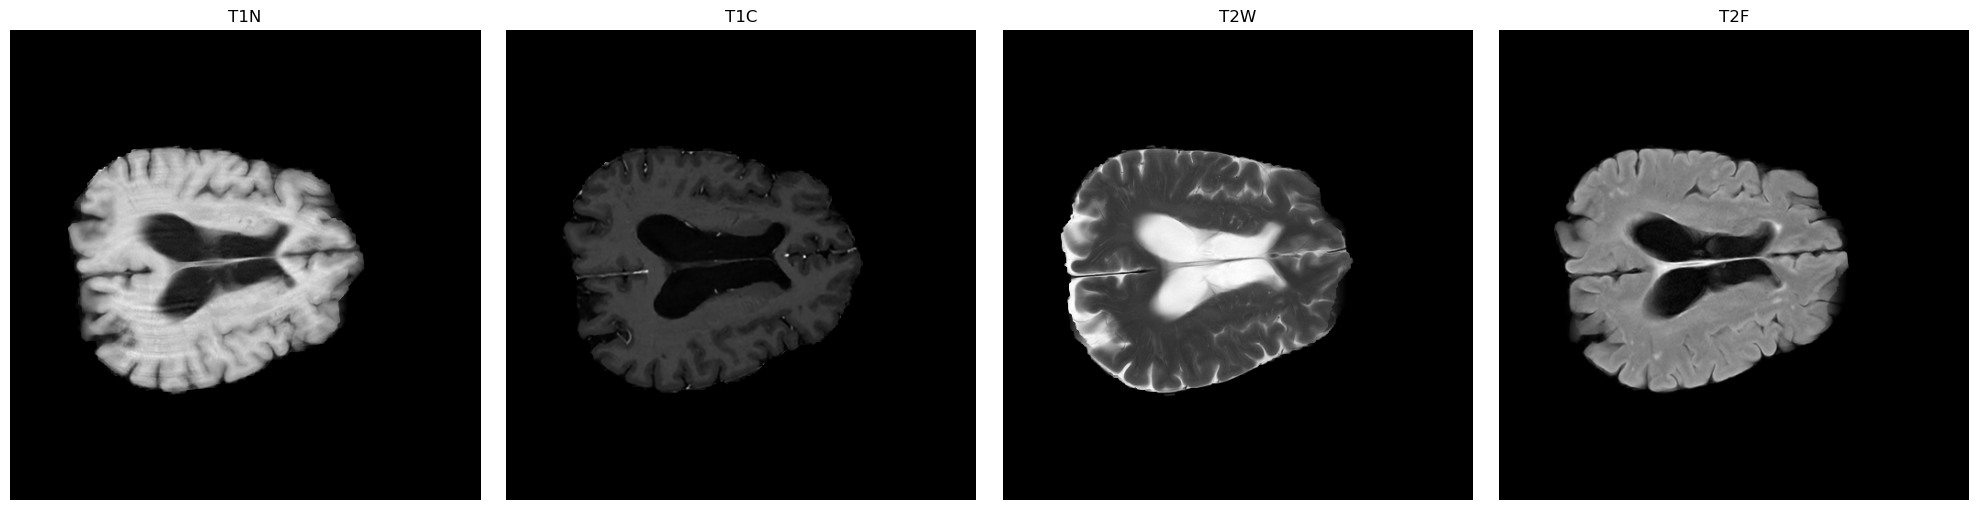

In [6]:
# now we can plot loaded cases
plot = True
for case_name, case_bundle in loaded_cases.items():
    print(f"\nCase: {case_name}")

    case_data = case_bundle['data']  # contains data
    case_info = case_bundle['info']  # contains extras like spacing/orientation

    for modality_name, volume in case_data.items():
        if volume is None:
            print(f"  {modality_name}: None")
        else:
            print(f"  {modality_name}: {volume.shape}")
            print(f'\t\t{case_info}')

    if plot is True:
        plot_inputs_grid_with_optional_segmentation(case_data, slice_idx=180, overlay_segmentation=True)

In [7]:
#test = load_case('./MICCAI-LH-BraTS2025-MET-Challenge-ValidationData/BraTS-MET-01184-001/',['BraTS-MET-01184-001-t1n.nii.gz', 'BraTS-MET-01184-001-t1c.nii.gz', 'BraTS-MET-01184-001-t2w.nii.gz', 'BraTS-MET-01184-001-t2f.nii.gz'])
#print(f'Example Shape: {test["t1n"].shape}')
#for slice_idx in range(60,180,5):
#    print(f"Plotting slice {slice_idx}/{249-1}")
#    plot_inputs_grid_with_optional_segmentation(
#        test,
#        slice_idx=slice_idx,
#        overlay_segmentation=False
#    )

{'original_shape': (249, 512, 512), 'corrected_shape': (512, 512, 249), 'suspicious_orientation': True, 'spacing': array([1.02999997, 0.5       , 0.5       ]), 'origin': array([-128.94985962,  -70.07897949, -128.35427856])}
Example sagittal Shape: (512, 512, 249)


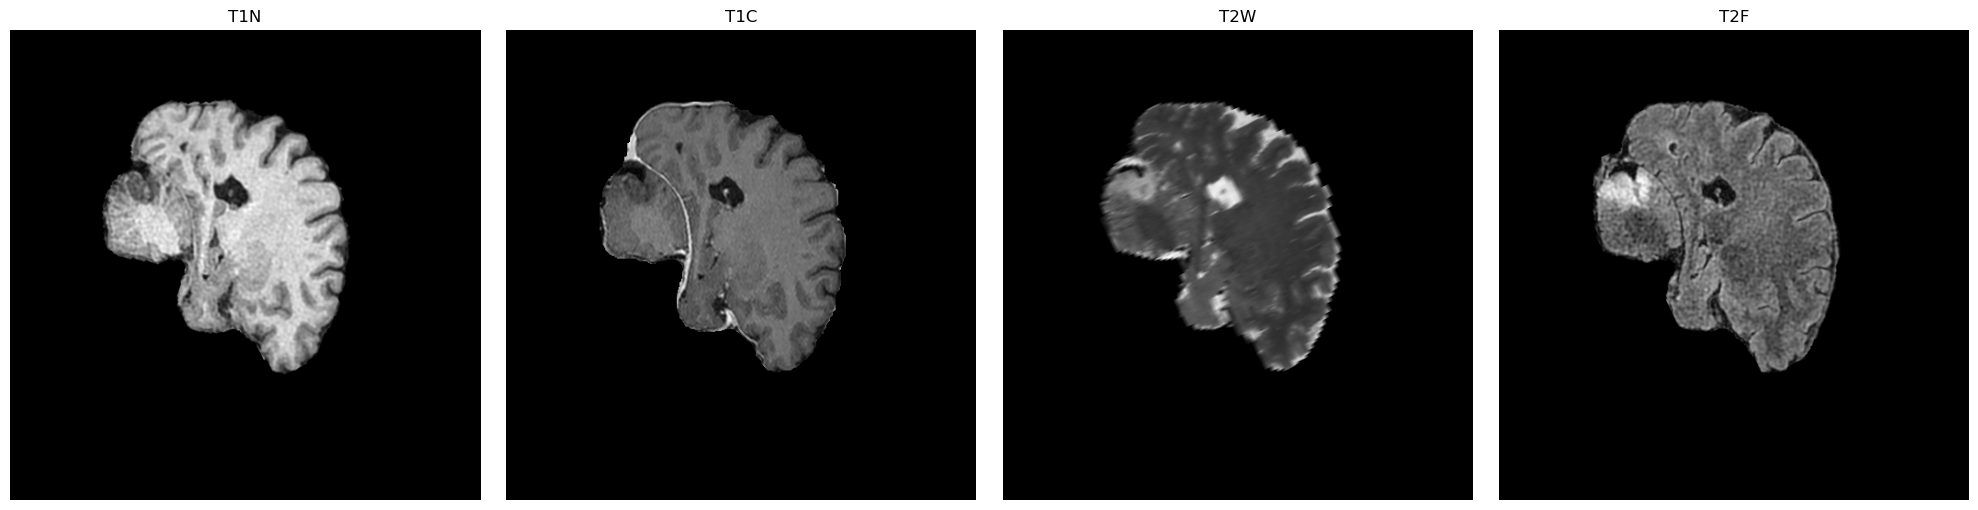

{'original_shape': (156, 512, 512), 'corrected_shape': (512, 512, 156), 'suspicious_orientation': True, 'spacing': array([1.20000005, 0.4883    , 0.4883    ]), 'origin': array([ -86.30132294,  -89.27867126, -159.58399963])}
Example sagittal Shape: (512, 512, 156)


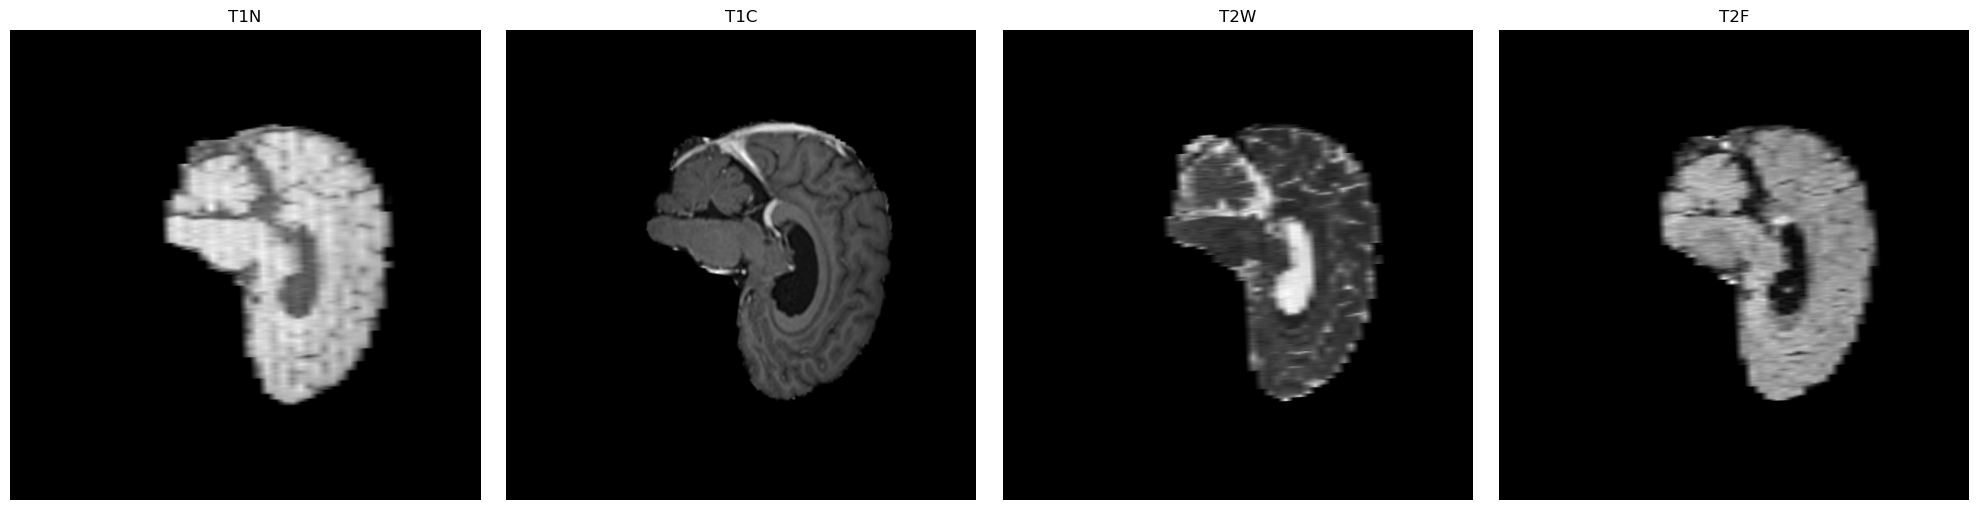

{'original_shape': (240, 240, 155), 'corrected_shape': (240, 240, 155), 'suspicious_orientation': False, 'spacing': array([1., 1., 1.]), 'origin': array([-239.,    0.,    0.])}
Example axial Shape: (240, 240, 155)


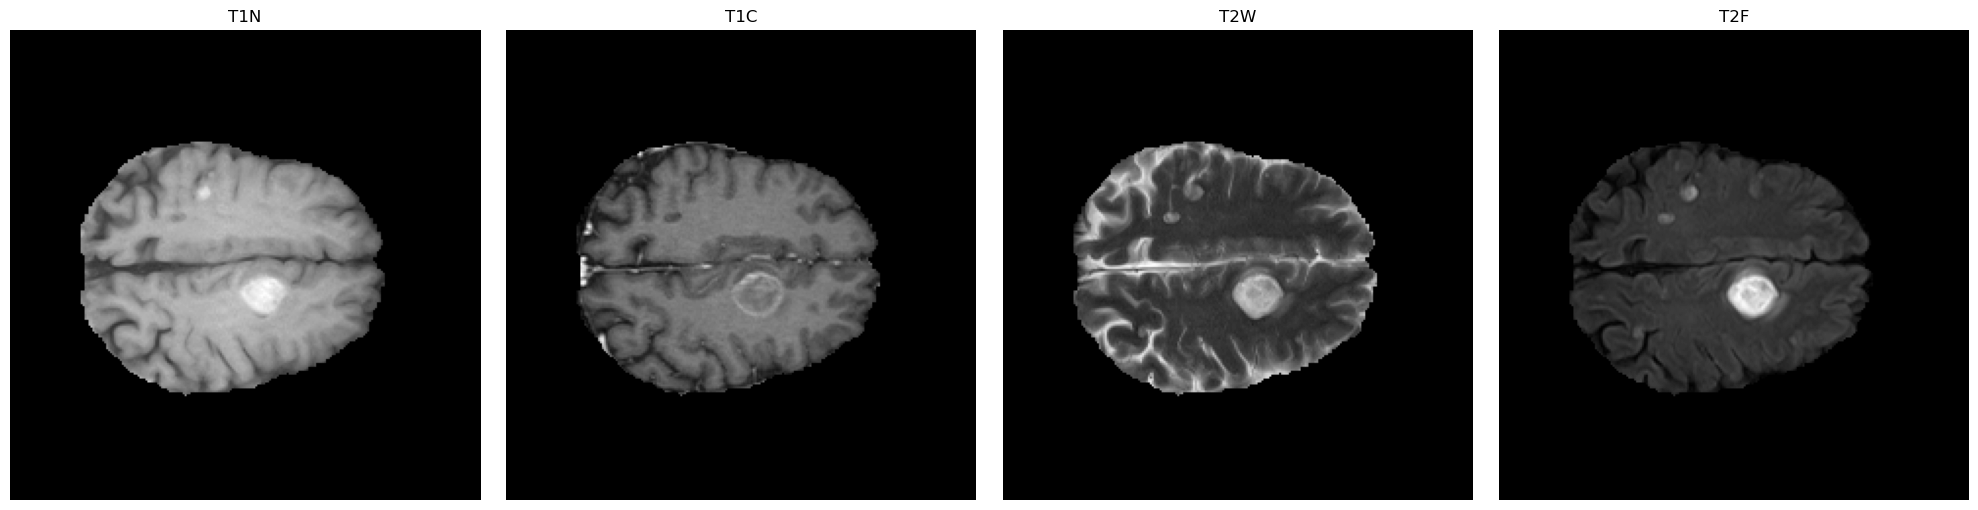

{'original_shape': (512, 257, 418), 'corrected_shape': (257, 418, 512), 'suspicious_orientation': True, 'spacing': array([0.5      , 1.0000068, 0.5      ]), 'origin': array([-128.33599854,  -88.12155151,  -64.06393433])}
Example axial Shape: (257, 418, 512)


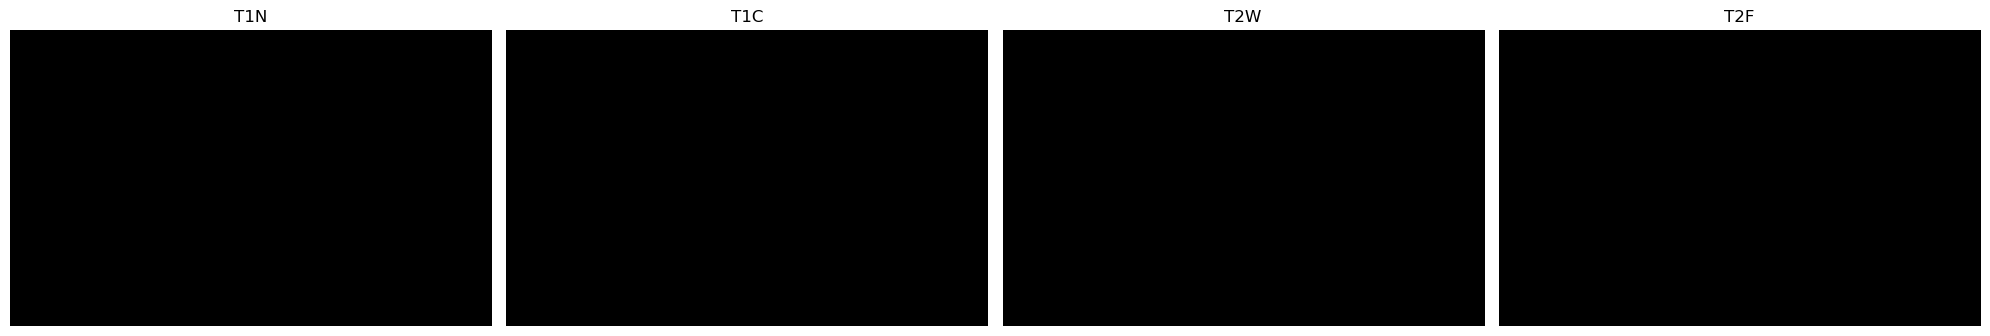

In [9]:
# ... apparently the input is not always recorded from the same axis... as far as i can tell most of the data is axial (from top to bottom)
# ... but some are sagittal (from left to right)
# ... in theory since this is volumetric we can apply some transforms/resampling in order to bring the other samples to the "correct" orientation
# ... i have tried some approaches but they are not working as expected (e.g. using torchio)... the results always looked weird and distorted
# ... initally i would suggest to just use the data with the "top-to-bot" orientation... and try to resample the others for the final model
# ... for this i have the info key (when calling load_case())... this should help to identify the samples
# ... "suspicious_orientation" key is to look for

# some examples of what i meant
tmp='BraTS-MET-01184-001'
test = load_case(f'./MICCAI-LH-BraTS2025-MET-Challenge-Validation/{tmp}/',[f'{tmp}-t1n.nii.gz', f'{tmp}-t1c.nii.gz', f'{tmp}-t2w.nii.gz', f'{tmp}-t2f.nii.gz'])
print(test[1])
test = test[0]
print(f'Example sagittal Shape: {test["t1n"].shape}')
plot_inputs_grid_with_optional_segmentation(
    test,
    slice_idx=100,
    overlay_segmentation=False
)
tmp='BraTS-MET-01284-003'
test = load_case(f'./MICCAI-LH-BraTS2025-MET-Challenge-Validation/{tmp}/',[f'{tmp}-t1n.nii.gz', f'{tmp}-t1c.nii.gz', f'{tmp}-t2w.nii.gz', f'{tmp}-t2f.nii.gz'])
print(test[1])
test = test[0]
print(f'Example sagittal Shape: {test["t1n"].shape}')
plot_inputs_grid_with_optional_segmentation(
    test,
    slice_idx=80,
    overlay_segmentation=False
)
tmp='BraTS-MET-00840-000'
test = load_case(f'./MICCAI-LH-BraTS2025-MET-Challenge-Validation/{tmp}/',[f'{tmp}-t1n.nii.gz', f'{tmp}-t1c.nii.gz', f'{tmp}-t2w.nii.gz', f'{tmp}-t2f.nii.gz'])
print(test[1])
test = test[0]
print(f'Example axial Shape: {test["t1n"].shape}')
plot_inputs_grid_with_optional_segmentation(
    test,
    slice_idx=100,
    overlay_segmentation=False
)
tmp='BraTS-MET-00625-000'
test = load_case(f'./MICCAI-LH-BraTS2025-MET-Challenge-Training/{tmp}/',[f'{tmp}-t1n.nii.gz', f'{tmp}-t1c.nii.gz', f'{tmp}-t2w.nii.gz', f'{tmp}-t2f.nii.gz'])
print(test[1])
test = test[0]
print(f'Example axial Shape: {test["t1n"].shape}')
plot_inputs_grid_with_optional_segmentation(
    test,
    slice_idx=100,
    overlay_segmentation=False
)


Case: BraTS-MET-00008-000
{'original_shape': (240, 240, 155), 'corrected_shape': (240, 240, 155), 'suspicious_orientation': False, 'spacing': array([1., 1., 1.]), 'origin': array([ -0., 239.,   0.])}
Example sagittal Shape: (240, 240, 155)
slice: 90


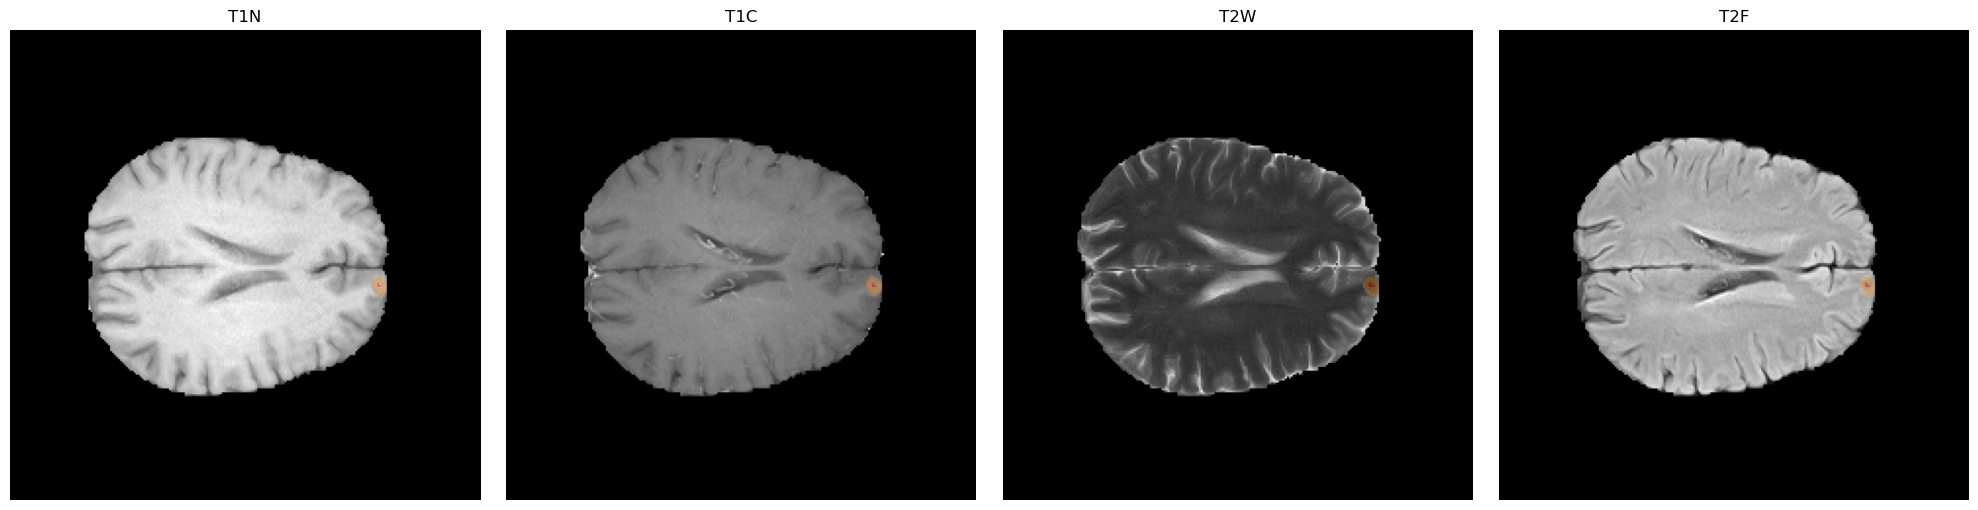

slice: 100


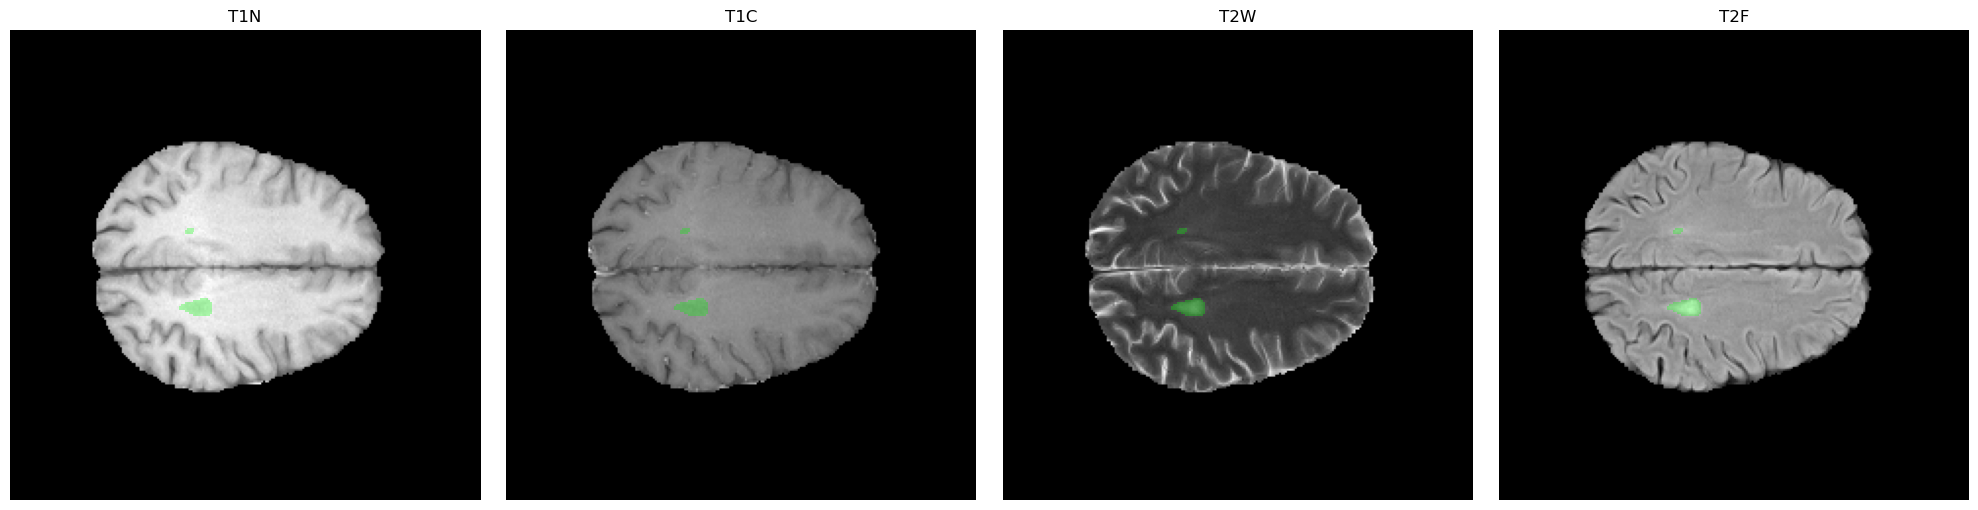

slice: 110


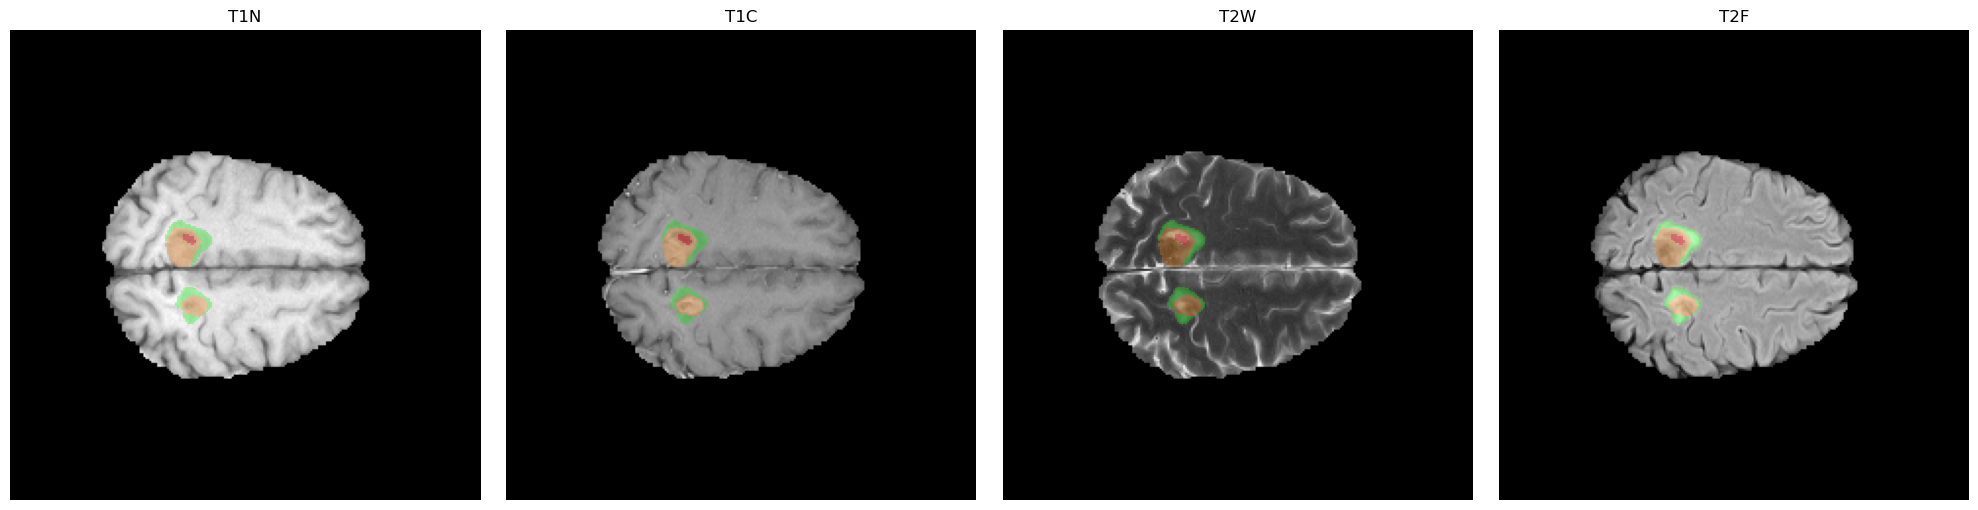

In [10]:
# if you want to plot the segmentation data you can do this as well
tmp='BraTS-MET-00008-000'
print(f'Case: {tmp}')
test = load_case(f'./MICCAI-LH-BraTS2025-MET-Challenge-Training/{tmp}/',[f'{tmp}-t1n.nii.gz', f'{tmp}-t1c.nii.gz', f'{tmp}-t2w.nii.gz', f'{tmp}-t2f.nii.gz', f'{tmp}-seg.nii.gz'])
print(test[1]) # info
test = test[0] # data

print(f'Example sagittal Shape: {test["t1n"].shape}')
print('slice: 90')
plot_inputs_grid_with_optional_segmentation(
    test,
    slice_idx=90,
    overlay_segmentation=True # if segmentation is avail just set this to true
)
print('slice: 100')
plot_inputs_grid_with_optional_segmentation(
    test,
    slice_idx=100,
    overlay_segmentation=True
)
print('slice: 110')
plot_inputs_grid_with_optional_segmentation(
    test,
    slice_idx=110,
    overlay_segmentation=True
)

In [20]:
# Now for pre-processing and data augmentation
# should contain only basic techniques that the participants of the previous years used
# also included some GPT comments to explain

# i do also think that we should probably do some of the pre-processing steps offline and not while creating the dataset... however i do not have the memory for this

train_transform_patch = tio.Compose([
    # Normalize each modality to zero mean and unit variance (z-score normalization),
    # computed per patient volume. Helps with numerical stability and model convergence.
    tio.ZNormalization(include=('t1n', 't1c', 't2w', 't2f')),

    # Resample all scans to a uniform voxel spacing of 1x1x1 mm.
    # Ensures consistent spatial resolution across datasets from different scanners.
    # Dunno if that is so simple... TODO: check if this is correct
    tio.Resample((1, 1, 1)),

    # Pad each dimension to be a multiple of 16 (useful for U-Net-like architectures).
    # Prevents size mismatch after downsampling/upsampling layers.
    tio.EnsureShapeMultiple(16),

    # Apply small random affine transformations (rotation, scaling).
    # Augments training data and improves generalization to real-world anatomical variability.
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10),

    # Introduce elastic deformations to mimic plausible anatomical distortions.
    # Strong data augmentation to improve model robustness.
    tio.RandomElasticDeformation(),

    # Add Gaussian noise to the image.
    # Helps with regularization and generalization to noisy clinical images.
    #tio.RandomNoise(),

    # Randomly flip left-right (sagittal symmetry in the brain allows this).
    # Simple yet effective augmentation for symmetry-aware models.
    # Dunno if we need this... TODO: check if we need this, but i guess it does not hurt
    tio.RandomFlip(axes=('LR',)),
])

train_transform_upsample = tio.Compose([
    tio.Resample((1, 1, 1)),
    tio.CropOrPad((512, 512, 512)),
    tio.ZNormalization(include=('t1n', 't1c', 't2w', 't2f')),
    tio.EnsureShapeMultiple(16),
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10),
    tio.RandomElasticDeformation(),
    tio.RandomNoise(),
    tio.RandomFlip(axes=('LR',)),
])

val_transform = tio.Compose([
    tio.ZNormalization(include=('t1n', 't1c', 't2w', 't2f')),
    tio.Resample((1, 1, 1)),
])

# pretty much includes most of the pre-processing/data augmentation steps from the last years best performing models
# what was and could also be done:
# - Resample to uniform voxel spacing to ensure isotropic voxels (should not be too hard... see last cell)
# - Skull stripping
# - Bias field correction, Correcting intensity inhomogeneities in MRI scans

# TODO: find a solution to work with fixed img dimensions...either crop or pad... probably not the best solution since img sizes differ heavily... might do patch-based sampling
# tio.GridSampler(patch_size=(240, 240, 128), patch_overlap=(32, 32, 16))


#Height (H):
#  Min:    240
#  Max:    512
#  Median: 256.0
#  Mean:   271.05
#
#Width (W):
#  Min:    240
#  Max:    512
#  Median: 256.0
#  Mean:   272.66
#
#Depth (Slices):
#  Min:    90
#  Max:    512
#  Median: 145.5
#  Mean:   134.19

# 2 Datasets:
#
# ... BrainMetDataset, BrainMetDatasetPreloaded
#       -> returns torchio.Subject; needs a SubjectsLoader
#       -> patch based sampling (e.g. 128x128x128) with overlap (e.g. 32x32x32);
#       
#       -> probably the better solution...

#       -> non-proloaded: lazy variant loads on getitem()
#       -> Preloaded: loads the complete dataset into memory on init() (only if hw allows)

In [ ]:
# Example usage up-pad
__train_dataset = BrainMetDataset(
    root_dir='./training_helper/', # dummy folder with only 5 cases
    case_contents=inspect_case_contents('./training_helper/'),
    with_segmentation=True,
    transforms=train_transform_upsample # does not work cause i pad and resample before znorm
)
__train_loader = DataLoader(
    __train_dataset,
    batch_size=1, # !!!
    shuffle=True,
    num_workers=4,
    prefetch_factor=2,
    persistent_workers=True
)
print(f'Up-"padded" batches:')
for batch in __train_loader:
    inputs = torch.cat([
        batch['t1n'][tio.DATA],
        batch['t1c'][tio.DATA],
        batch['t2w'][tio.DATA],
        batch['t2f'][tio.DATA],
    ], dim=1).to(device)           # (B, 4, H, W, D)

    targets = batch['seg'][tio.DATA].squeeze(1).to(device) # (B, H, W, D)

    print(inputs.shape)
    print(targets.shape)
    break

In [21]:
# example usage patched
import torchio as tio

class GridSamplerWrapper(tio.data.PatchSampler):
    def __init__(self, patch_size, patch_overlap=(0, 0, 0), padding_mode=None):
        self.patch_size = patch_size
        self.patch_overlap = patch_overlap
        self.padding_mode = padding_mode

    def __call__(self, subject):
        return tio.GridSampler(
            subject=subject,
            patch_size=self.patch_size,
            patch_overlap=self.patch_overlap,
            padding_mode=self.padding_mode
        )


__train_dataset = BrainMetDatasetPreloaded(
    root_dir='./training_helper/', # dummy folder with only 5 cases
    case_contents=inspect_case_contents('./training_helper/'),
    with_segmentation=True,
    transforms=train_transform_patch
)

subjects_dataset = tio.SubjectsDataset(__train_dataset)

# define patch size
sampler = GridSamplerWrapper(patch_size=(128, 128, 128), patch_overlap=(32, 32, 32))

# queue always keeps 300 samples... max patches per sample = 100 (if there are less possible -> less)
patches_queue = tio.Queue(
    subjects_dataset=subjects_dataset,
    max_length=300,
    samples_per_volume=100,
    sampler=sampler,
    num_workers=4,
    shuffle_subjects=True,
    shuffle_patches=True,
)

from torchio.data import SubjectsLoader
__train_loader = SubjectsLoader(
    patches_queue,
    batch_size=16,
    #num_workers=0,  # on windows
    num_workers=4,
)
print(f'Patch based batches:')
for batch in __train_loader:
    inputs = torch.cat([
        batch['t1n'][tio.DATA],
        batch['t1c'][tio.DATA],
        batch['t2w'][tio.DATA],
        batch['t2f'][tio.DATA],
    ], dim=1).to(device)

    targets = batch['seg'][tio.DATA].squeeze(1).to(device)
    
    # cuts input into cubes of 128^3 with an overlap of 32
    print(inputs.shape)
    print(targets.shape)
    break



Total cases: 5
Patch based batches:
torch.Size([8, 4, 128, 128, 128])
torch.Size([8, 128, 128, 128])


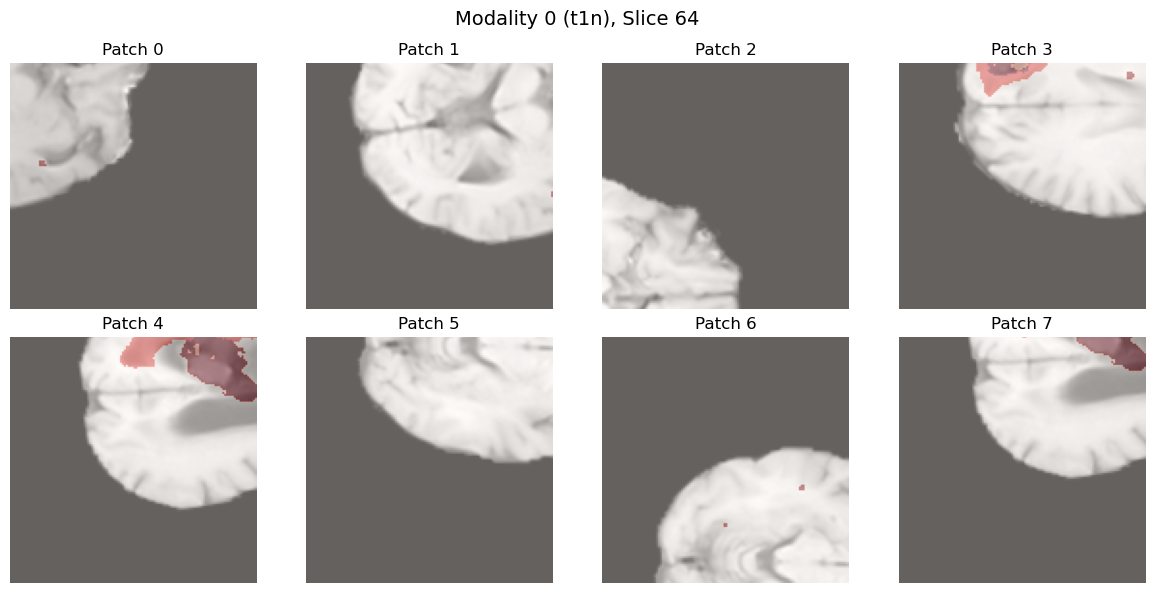

In [27]:
import matplotlib.pyplot as plt

# Ensure inputs is on CPU
inputs_cpu = inputs.to('cpu')  # (B, 4, H, W, D)
targets_cpu = targets.to('cpu')

batch_size = inputs_cpu.shape[0]
modality_idx = 0  # 0 = t1n
z = inputs_cpu.shape[-1] // 2  # middle slice

# Set up grid plot
cols = 4
rows = (batch_size + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

for i in range(batch_size):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]
    img_slice = inputs_cpu[i, modality_idx, :, :, z].numpy()
    seg_slice = targets_cpu[i, :, :, z].numpy()
    
    ax.imshow(img_slice, cmap='gray')
    ax.imshow(seg_slice, cmap='Reds', alpha=0.4)  # overlay with transparency
    ax.set_title(f'Patch {i}')
    ax.axis('off')

# Hide any unused subplots
for i in range(batch_size, rows * cols):
    row = i // cols
    col = i % cols
    ax = axes[row, col] if rows > 1 else axes[col]
    ax.axis('off')

plt.suptitle(f"Modality {modality_idx} (t1n), Slice {z}", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
root_dir = './MICCAI-LH-BraTS2025-MET-Challenge-Training/'
case_contents = inspect_case_contents(root_dir)

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
filtered_contents = filter_suspicious_cases(root_dir, case_contents)
# excludes and counts all cases with "suspicious_orientation" in the info dict
# TODO: remove once we found a solution to the orientation problem

# 3 cases for valid
# 2 cases for train
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

train_dataset = BrainMetDataset(
    root_dir=root_dir,
    case_contents=filtered_contents,
    with_segmentation=False,
    transforms=train_transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    prefetch_factor=2,
    persistent_workers=True
)

In [ ]:
# for validation.... seg=False
val_dataset = BrainMetDataset(
    root_dir='./MICCAI-LH-BraTS2025-MET-Challenge-ValidationData/',
    case_contents=inspect_case_contents('./MICCAI-LH-BraTS2025-MET-Challenge-ValidationData/'),
    with_segmentation=False,
    transforms=val_transform
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    prefetch_factor=2,
    persistent_workers=True
)

In [ ]:
# sum stats
import numpy as np

root_dir = "./MICCAI-LH-BraTS2025-MET-Challenge-Training/"

# first extract all cases and their contents from dir (only names)
case_contents = inspect_case_contents(root_dir)

# load up to 100 cases
loaded_cases = load_all_cases(root_dir, case_contents, limit=100, seed=6)
print(f"Total cases loaded: {len(loaded_cases)}")

# Collect shapes of available t1c volumes
shapes = []

for case_name, case_entry in loaded_cases.items():
    case_data = case_entry['data']
    if case_data['t1c'] is not None:
        shape = case_data['t1c'].shape
        shapes.append(shape)
        print(f"{case_name}: {shape}")

# Convert to numpy for easy axis-wise stats
shape_array = np.array(shapes)  # shape: (N, 3)

# Compute and print statistics
for axis, label in enumerate(['Height (H)', 'Width (W)', 'Depth (Slices)']):
    values = shape_array[:, axis]
    print(f"\n{label}:")
    print(f"  Min:    {np.min(values)}")
    print(f"  Max:    {np.max(values)}")
    print(f"  Median: {np.median(values)}")
    print(f"  Mean:   {np.mean(values):.2f}")


In [ ]:
# inference when patched
import torchio as tio

subject = validation_subject  # one full-volume subject
sampler = tio.GridSampler(subject, patch_size=(128, 128, 128), patch_overlap=(32, 32, 32))
aggregator = tio.GridAggregator(sampler)

for patch in sampler:
    inputs = torch.cat([
        patch['t1n'][tio.DATA],
        patch['t1c'][tio.DATA],
        patch['t2w'][tio.DATA],
        patch['t2f'][tio.DATA],
    ], dim=0).unsqueeze(0).to(device)  # (1, 4, H, W, D)

    with torch.no_grad():
        logits = model(inputs)  # (1, C, H, W, D)
        pred_patch = torch.argmax(logits, dim=1)  # (1, H, W, D)

    aggregator.add_batch(pred_patch.cpu(), patch[tio.LOCATION])

# Reconstruct full prediction
pred_full = aggregator.get_output_tensor()
